In [8]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia

In [1]:
# HSC fits file to be read
file_path = '../data/HECTOMAP_stars.fits'

# Read in the fits file and close it
hdul = fits.open(file_path)
data = hdul[1].data
hdul.close()

# Print the column names and length of the data
print(data.columns.names)
print(len(data))

# Get object IDs, parent IDs, ira, idec and imagnitudes and add to pandas dataframe
hsc_y1 = pd.DataFrame({'object_id': data['object_id'], 'parent_id': data['parent_id'], 'ra': data['ira'], 'dec': data['idec'], 'imag': data['imag_psf']})

# Combine ra and dec into a sky coord array
hsc_y1['coord'] = SkyCoord(ra=hsc_y1['ra'], dec=hsc_y1['dec'], unit = 'deg')

['object_id', 'parent_id', 'ira', 'idec', 'imag_psf', 'imag_psf_err', 'iflux_psf', 'iflux_psf_err', 'iflux_psf_flags', 'ishape_sdss_ixx', 'ishape_sdss_iyy', 'ishape_sdss_ixy', 'ishape_sdss_ixx_var', 'ishape_sdss_iyy_var', 'ishape_sdss_ixy_var', 'ishape_sdss_psf_ixx', 'ishape_sdss_psf_iyy', 'ishape_sdss_psf_ixy', 'tract', 'icalib_psf_used', 'merge_peak_g', 'merge_peak_r', 'merge_peak_i', 'merge_peak_z', 'merge_peak_y', 'icountinputs', 'ideblend_has_stray_flux', 'iflags_pixel_bright_object_center', 'iflags_pixel_bright_object_any', 'iblendedness_abs_flux', 'iflags_negative', 'ideblend_too_many_peaks', 'ideblend_parent_too_big', 'icentroid_naive_flags', 'iflags_pixel_interpolated_any', 'iflags_pixel_saturated_any', 'iflags_pixel_cr_any', 'iflags_pixel_suspect_any']
72640


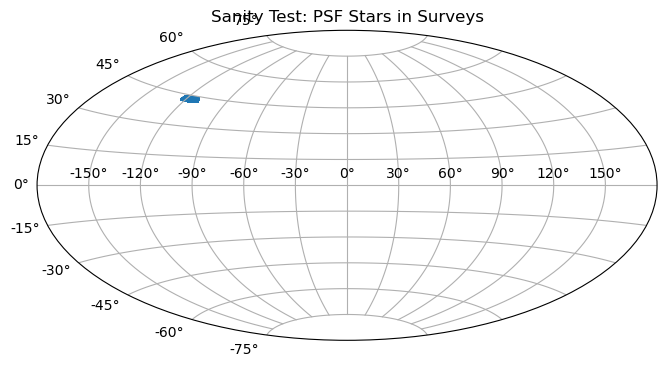

In [35]:
# Function to plot the ra and dec of the PSF stars
def plot_sanity_test(coord):
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.title("Sanity Test: PSF Stars in Surveys")
    plt.grid(True)
    ra_rad = np.array([c.ra.wrap_at(180 * u.deg).radian for c in coord])
    dec_rad = np.array([c.dec.radian for c in coord])
    plt.scatter(ra_rad, dec_rad, s=0.1, alpha=0.8)
    plt.show()
    
# Plot the ra and dec of the PSF stars
plot_sanity_test(hsc_y1['coord'])


In [2]:
# Get 2D array of ra and dec from dataframe
ra_dec = np.array([hsc_y1['ra'], hsc_y1['dec']]).T

# Perform clustering
number_of_clusters = 10
cents = kmeans(ra_dec, number_of_clusters)
centroids = cents[0]
cluster_num = vq(ra_dec, centroids)

# Generate cluster info df
max_dist_pts = {i:[np.array([k for k in cluster_num[1][cluster_num[0] == i]]).max()] for i in range(number_of_clusters)}
cluster_info = pd.DataFrame(max_dist_pts).T
cluster_info.columns = ["max_dist"]
cluster_info["clusterno"] = cluster_info.index
cluster_info["dists"] = [cluster_num[1][cluster_num[0] == i] for i in cluster_info["clusterno"]]
cluster_info["centroids"] = list(centroids)

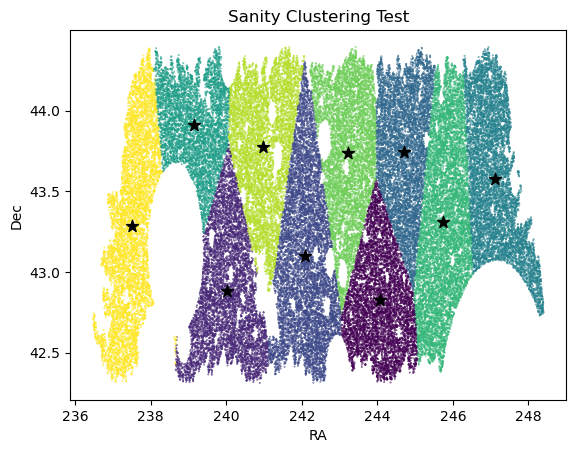

In [3]:
# Sanity check: plot clustering result
def plot_cluster_test(ra_dec, centroids, cluster_num):
    
    # scatter plot of K-Means cluster
    plt.scatter(ra_dec[:, 0],
                ra_dec[:, 1],
                c=cluster_num[0], s  = 0.1)
    
    # Centroid of the clusters
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                marker='*',
                s=80,
                color='black')

    plt.title("Sanity Clustering Test")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    
# plot cluster test
plot_cluster_test(ra_dec, cents[0], cluster_num)

In [11]:
def query_gaia_for_cluster(ra, dec, dist):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Gaia.ROW_LIMIT = -1
    job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    return gaia_table

In [42]:
clust0_info = cluster_info.loc[0]
gaia0_tab = query_gaia_for_cluster(clust0_info["centroids"][0], clust0_info["centroids"][1], clust0_info["max_dist"])
cluster0 = SkyCoord(ra_dec[cluster_num[0] == 0] * u.deg)
gaia0 = SkyCoord(ra = gaia0_tab['ra'], dec = gaia0_tab['dec'], unit=u.deg)
idx_clust, sep2d_clust, _ = cluster0.match_to_catalog_sky(gaia0)

INFO: Query finished. [astroquery.utils.tap.core]


In [45]:
# Create table with gaia0 coords, cluster0 coords, and flag for matched stars
comb_stars = pd.DataFrame({'matched': np.zeros(len(cluster0))})
comb_stars.loc[sep2d_clust < 1 * u.arcsec] = 1
comb_stars['gaia0'] = gaia0[idx_clust]
comb_stars['cluster0'] = cluster0
comb_stars['sep2d'] = sep2d_clust.arcsec # in arcsec

comb_stars

,matched,gaia0,cluster0,sep2d
0,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",32.179662
1,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...",28.072755
2,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",0.152504
3,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...",36.498279
4,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.5...",29.125920
...,...,...,...,...
6776,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",20.309281
6777,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",13.474841
6778,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",41.711428
6779,0.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...","<SkyCoord (ICRS): (ra, dec) in deg\n (243.6...",7.394455


Text(0.5, 1.0, 'Matched Stars: Separation in Arcsec')

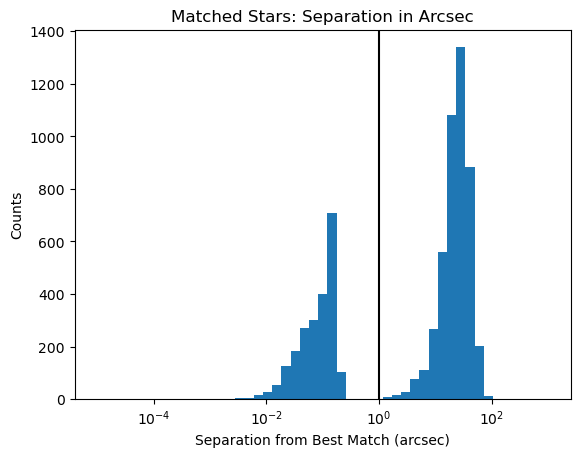

In [46]:
plt.hist(comb_stars["sep2d"], bins = np.logspace(-5, 3))
plt.semilogx()
plt.axvline(1, color = "k")
plt.ylabel("Counts")
plt.xlabel("Separation from Best Match (arcsec)")
plt.title("Matched Stars: Separation in Arcsec")

In [47]:
hsc_final = hsc_stars.to_table().to_pandas()
gaia_final = gaia_stars.to_table().to_pandas()

NameError: name 'hsc_stars' is not defined

Text(0.5, 1.0, 'Post-Matching, Sample Region')

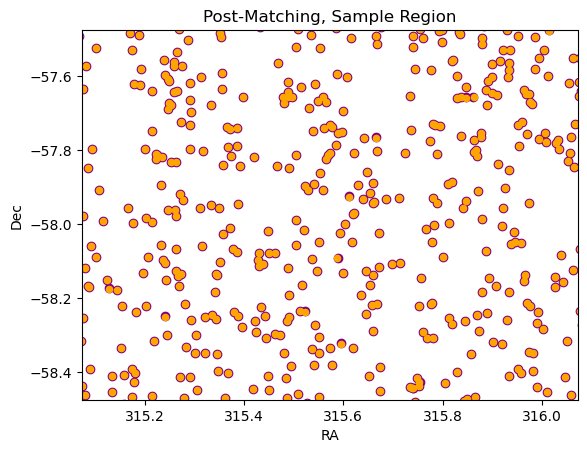

In [ ]:
plt.scatter(hsc_final["ra"], hsc_final["dec"], color = "purple")
plt.scatter(gaia_final["ra"], gaia_final["dec"], s = 20, color = "orange")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.xlim(centroids[0][0] + 360 - 0.5, centroids[0][0] + 360+ 0.5)
plt.ylim(centroids[0][1] - 0.5, centroids[0][1] + 0.5)
plt.title("Post-Matching, Sample Region")

In [ ]:
hsc_final.to_table().to_pandas()

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the center coordinates of your region and the search radius
center_coordinates = SkyCoord(ra=centroids[0][0], dec=centroids[0][1], unit=(u.degree, u.degree))
search_radius = 1.0 * u.arcsec  # Adjust the radius as needed
max_no = 100

# Query GAIA DR2 catalog for stars within the specified region
# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE 1 = CONTAINS(
#    POINT({center_coordinates.ra.degree}, {center_coordinates.dec.degree}),
#    CIRCLE(ra, dec, {search_radius.value}))
# """

# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE DISTANCE({center_coordinates.ra.degree}, {center_coordinates.dec.degree}, ra, dec) < {search_radius.value}
# """

# query = f"""
# SELECT ra, dec, DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) AS ang_sep
# FROM gaiadr3.gaia_source
# WHERE DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) <  300./60.
# ORDER BY ang_sep ASC
# """

# AND phot_g_mean_mag < 21

# AND (phot_g_mean_mag BETWEEN 15.0 AND 21.0)
# AND (astrometric_excess_noise < power(10,0.15*(phot_g_mean_mag-15)+0.25))
# AND (phot_bp_rp_excess_factor > power(bp_rp, 2)*0.015+1.0)
# AND (phot_bp_rp_excess_factor < power(bp_rp, 2)*0.06+1.3)
Gaia.ROW_LIMIT = -1
job = Gaia.cone_search_async(center_coordinates, radius=u.Quantity(3.0, u.deg), columns=["ra", "dec"])
# job = Gaia.launch_job(query)
result_table = job.get_results()
gaia_table = result_table.to_pandas()
gaia_table["ra"] = wrap_ra(gaia_table["ra"])
# Print the result table (contains information about the stars)
print(result_table)